In [ ]:
from audioop import cross

import numpy as np
from numpy.lib.recfunctions import join_by

data = np.load('../data_recording/DATA_8mhz.npy', 'r', allow_pickle=True, )[0]
data_seconds = np.array_split(data,
                              5)  # split array into 1 second chunks (20,000,000 samples at 4MHz is 5 seconds) (4,000,000 samples each)
data_ms = np.array_split(data_seconds[0], 1000)  # split 1 second into ms chunks (4,000 samples each)
ms_2 = np.ravel(data_ms[18:20])  # 2 milliseconds with a packet (8,000 samples)
us = np.array_split(ms_2, 2000)  # split milliseconds into microseconds (4 samples each)

In [49]:
# probably a packet (data that is not in the center on a IQ plot)
packet_signal_2948 = np.ravel(us[757:757 + 737])

packet_signal_4096 = np.ravel(us[757:757 + 1024])  # 4 samples * 1024

### Visualisation

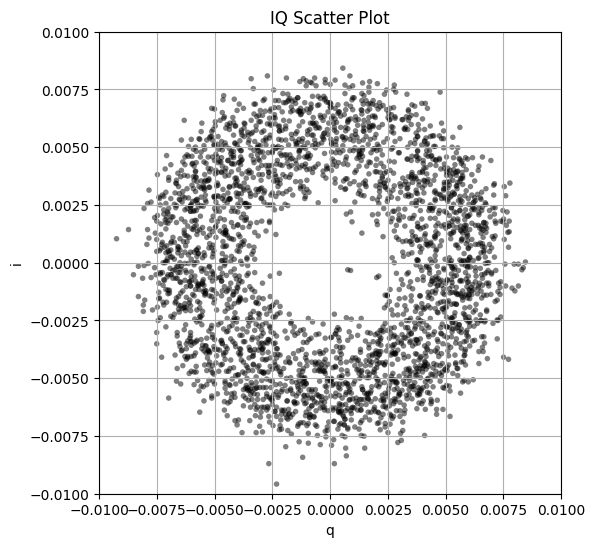

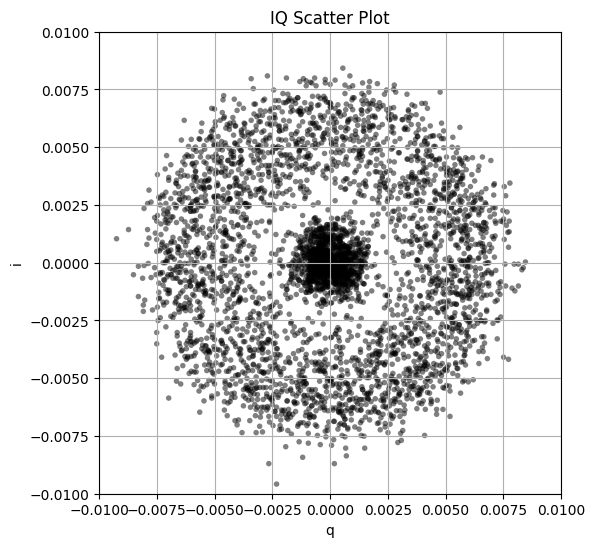

In [41]:
from matplotlib import pyplot as plt


def plot_basic(graph_data, axis_limits=(-0.01, 0.01), radius_setting=5, opacity=50, color='blueviolet',
               name="IQ Scatter Plot", y_name="i", x_name="q"):
    radius = 10 ** (((3 / 10) * (radius_setting - 1)))  # range between -1 and 2 where radius setting is 1-10

    x = np.real(graph_data)
    y = np.imag(graph_data)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Set the axis limits
    ax.set_xlim(axis_limits[0], axis_limits[1])
    ax.set_ylim(axis_limits[0], axis_limits[1])

    # Plot the scatter plot with circles
    ax.scatter(x, y, s=radius, color=color, alpha=opacity / 100, edgecolors='none')

    # Set aspect ratio to be equal
    ax.set_aspect('equal')

    # Add grid and labels
    ax.grid(True)
    ax.set_title(name)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

    # Show the plot
    plt.show()


plot_basic(packet_signal_2948, color='#000')
plot_basic(packet_signal_4096, color='#000')

In [95]:
def plot_eye_cmp(s1, s2, fs, sps, s1_title='', s2_title='', sup_title='', compensate_oqpsk=True, disable_combo=False,
                 combo_title: None | str = None, combo_opacity=(100, 100)):
    if combo_title is None:
        combo_title = f"{s1_title}/{s2_title}"

    color1 = "#58A4B0"  # blue
    color2 = "#F44E3F"  # red
    fig, (ax1, ax2, ax_combo) = (None, (None, None, None))
    if disable_combo:
        fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")
    else:
        fig, (ax1, ax2, ax_combo) = plt.subplots(1, 3, layout="constrained")

    ax1.set_title(s1_title)
    ax2.set_title(s2_title)
    if not disable_combo:
        ax_combo.set_title(combo_title)

    ax1.set_box_aspect(1)
    ax2.set_box_aspect(1)
    if not disable_combo:
        ax_combo.set_box_aspect(1)

    s1I, s1Q = (np.real(s1), np.imag(s1))
    s2I, s2Q = (np.real(s2), np.imag(s2))
    #compensate_oqpsk=False
    if compensate_oqpsk:
        # compensate for O-QPSK by shifting Q-phase back by T_c
        s1I, s1Q = (s1I[0:-sps // 2], s1Q[sps // 2:])
        s2I, s2Q = (s2I[0:-sps // 2], s2Q[sps // 2:])
    ax1.scatter(s1I, s1Q, 1, marker='.', color=color1)
    ax2.scatter(s2I, s2Q, 1, marker='.', color=color2)

    if not disable_combo:
        ax_combo.scatter(s1I, s1Q, 1, marker='.', color=color1, alpha=combo_opacity[0] / 100)
        ax_combo.scatter(s2I, s2Q, 1, marker='.', color=color2, alpha=combo_opacity[1] / 100)

    fig.suptitle(sup_title)
    plt.show()

In [93]:
def plot_samples(samples, samples_expected, time_offset_coarse, xlim=[0, 150]):
    samples_offset = np.arange(len(samples_expected)) - time_offset_coarse

    fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
    ax1.plot(np.real(samples), 'o-', label='off-board')
    ax2.plot(np.imag(samples), 'o-')
    ax1.plot(samples_offset, np.real(samples_expected), 'o-', label='expected')
    ax2.plot(samples_offset, np.imag(samples_expected), 'o-')
    ax1.set_title('In-phase')
    ax2.set_title('Quadrature-phase')
    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)
    fig.legend()
    plt.show()

## Receiver Pipeline

In [73]:
sampling_freq = 4e6
samples_per_symbol = 4

In [125]:
# symbol to chip mapping according to 802.15.4-2006 standard, Figure 20
ieee802154_chip_map = np.array([
    [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
    [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0],
    [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
    [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
    [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
]) * 2 - 1
ieee802154_chip_map

array([[ 1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1,
        -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1],
       [ 1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1,
        -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1],
       [-1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,
         1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1],
       [-1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1,
         1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1],
       [-1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1,
         1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1],
       [-1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1,
         1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1],
       [ 1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1,
        -1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1

### Gain Control

In [75]:
def normalize(samples):
    return samples / np.mean(np.abs(samples))

### Matched Filter

In [76]:

def filter(samples, sps, debug=False):
    n = np.arange(sps)
    pulse = np.sin(np.pi - np.pi * n / sps, dtype=np.float32)

    samples_filtered = np.convolve(samples, pulse, 'same') / (sps / 2)  #[sps//2-1:]

    if debug:
        xlim = [-10, 110]
        fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
        ax1.plot(np.real(samples), '.-', label='before')
        ax1.plot(np.real(samples_filtered), '.-', label='after')
        ax2.plot(np.imag(samples), '.-')
        ax2.plot(np.imag(samples_filtered), '.-')
        ax1.set_title('In-phase')
        ax2.set_title('Quadrature-phase')
        ax1.set_xlim(xlim)
        ax2.set_xlim(xlim)
        fig.legend()
        plt.show()
        plot_eye_cmp(samples, samples_filtered, sampling_freq, samples_per_symbol)
        plot_eye_cmp(samples, samples_filtered, sampling_freq, samples_per_symbol, compensate_oqpsk=False)

    #return samples
    return samples_filtered


### Frequency Synchronization

In [77]:
def sync_freq(samples, fs, N, sps, debug=False):
    # triangle window
    # window = sp.signal.triang(N)

    # Gaussian window (r=8)
    t = np.arange(N) - N / 2
    window = np.exp(- 8 * 8 * t * t / (2 * N * N), dtype=np.float32)

    # coarse freq. recovery for OQPSK
    # see http://jontio.zapto.org/hda1/oqpsk.html
    samples_squared = window[:len(samples)] * samples[:len(window)] * samples[:len(window)]
    fft = np.abs(np.fft.fft(samples_squared, N).astype(np.complex64))

    # find spectral peaks in both sides of spectrum,
    # in regions around the symbol rate (N/sps)
    bin_left = -N // sps
    bin_right = N // sps
    bin_range = 200  # ~200kHz on original frequency scale
    max_left_idx = np.argmax(fft[bin_left - bin_range:bin_left + bin_range]) + bin_left - bin_range
    max_right_idx = np.argmax(fft[bin_right - bin_range:bin_right + bin_range]) + bin_right - bin_range

    # parabolic interpolation
    # idx = max_left_idx
    # max_left_idx = idx + (fft[idx+1] - fft[idx-1])/(2*(2*fft[idx] - fft[idx+1] - fft[idx-1]))
    # idx = max_right_idx
    # max_right_idx = idx + (fft[idx+1] - fft[idx-1])/(2*(2*fft[idx] - fft[idx+1] - fft[idx-1]))

    # Gaussian interpolation
    idx = max_left_idx
    max_left_idx = idx + np.log(fft[idx + 1] / fft[idx - 1], dtype=np.float32) / (
            2 * np.log(fft[idx] * fft[idx] / (fft[idx + 1] * fft[idx - 1]), dtype=np.float32))
    idx = max_right_idx
    max_right_idx = idx + np.log(fft[idx + 1] / fft[idx - 1], dtype=np.float32) / (
            2 * np.log(fft[idx] * fft[idx] / (fft[idx + 1] * fft[idx - 1]), dtype=np.float32))

    freq_resolution = np.float32(fs / N / 2)
    cfo = np.float32((max_left_idx + max_right_idx) / 2) * freq_resolution

    if debug:
        freq = np.fft.fftfreq(N, 1 / fs) / 2
        plt.plot(freq, fft)
        plt.axvspan((bin_left - bin_range) * freq_resolution, (bin_left + bin_range) * freq_resolution, alpha=0.5,
                    color='g')
        plt.axvspan((bin_right - bin_range) * freq_resolution, (bin_right + bin_range) * freq_resolution, alpha=0.5,
                    color='g')
        plt.axvline(max_left_idx * freq_resolution, c='g', ls='--')
        plt.axvline(max_right_idx * freq_resolution, c='g', ls='--')
        plt.axvline(cfo, c='r', ls='--')
        plt.show()

    # correct frequency
    t = np.linspace(0, len(samples) / fs, len(samples), dtype=np.float32)

    # return corrected signal and CFO estimate
    return (samples * np.exp(-1j * 2 * np.pi * cfo * t, dtype=np.complex64), cfo)

### Phase Synchronization

In [78]:
def sync_phase(samples, sps, damping_factor=0.707, loop_bandwidth=0.01):
    # phase and thereby fine freq. synchronization for OQPSK
    # see https://www.mathworks.com/help/comm/ref/comm.carriersynchronizer-system-object.html#bultrxw-19

    # calculate constants
    K_p = 2
    K_0 = sps
    theta = loop_bandwidth / (damping_factor + 0.25 / damping_factor)
    d = 1 + 2 * damping_factor * theta + theta * theta
    gain_integrator = (4 * theta * theta / d) / (K_p * K_0)
    gain_proportional = (4 * damping_factor * theta / d) / (K_p * K_0)

    # initialize variables
    phase_offset_vec = np.zeros(len(samples), dtype=np.float32)
    phase_offset = 0
    loop_filter = 0
    dds_integral = 0
    dds_prev = 0
    samples_corrected = np.array(samples)
    prev_half_symbol = np.zeros(sps // 2, dtype=np.complex64)

    # go over samples one by one
    for i in range(len(samples)):
        # shift samples from last half symbol
        prev_half_symbol = np.roll(prev_half_symbol, -1)
        prev_half_symbol[-1] = samples[i]

        # compensate samples according to current phase_offset
        sample_prev = prev_half_symbol[0] * np.exp(-1j * phase_offset)
        sample = samples[i] * np.exp(-1j * phase_offset)
        samples_corrected[i] = sample

        # find phase error (decision-directed approach)
        phase_error = np.sign(np.real(sample_prev)) * np.imag(sample_prev) - np.sign(np.imag(sample)) * np.real(sample)

        # loop filter
        loop_filter += gain_integrator * phase_error

        # direct digital synthetizer implemented as integrator
        dds_integral += dds_prev
        dds_prev = gain_proportional * phase_error + loop_filter

        phase_offset = dds_integral
        phase_offset_vec[i] = phase_offset

    return (samples_corrected, phase_offset_vec)

In [59]:
def sync_phase2(samples, sps, resolution=16, cutoff=1500, threshold=0.35, debug=False):
    # todo: maybe implement binary search for enhanced efficiency?

    phases = np.arange(0, 1, 1 / resolution) * np.pi / 2
    outliers = np.empty(len(phases))
    for i, phase in enumerate(phases):
        samples_phase = samples[:cutoff] * np.exp(1j * phase)

        # todo: debug
        # plt.scatter(np.real(samples_phase)[0:-sps//2], np.imag(samples_phase)[sps//2:], 1, marker='.')
        # plt.gca().set_aspect(1)
        # plt.show()

        # compensate for OQPSK to get X-shape
        samples_phaseI, samples_phaseQ = np.real(samples_phase[0:-samples_per_symbol // 2]), np.imag(
            samples_phase[samples_per_symbol // 2:])

        # count all samples which are more than `threshold` away from X-shape as outliers
        outliers[i] = np.count_nonzero(np.abs(np.abs(samples_phaseI) - np.abs(samples_phaseQ)) > threshold)

    if debug:
        plt.plot(phases * 180 / np.pi, outliers, '.-')
        plt.xlabel('Phase Shift [°]')
        plt.ylabel('amount of samples outside X-shape')
        plt.show()

    phase_shift = phases[np.argmin(outliers)]
    samples_phase = samples * np.exp(1j * phase_shift)

    return samples_phase, phase_shift

### Time Synchronization

In [60]:
def sync_time(samples, sps, damping_factor=1, loop_bandwidth=0.01, gain_detector=2.7):
    # time synchronization for OQPSK
    # followed symbolSyncCodegen since symbolSync is natively implemented in C/C++ (Matlab MEX file)
    # see https://www.mathworks.com/help/comm/ref/comm.symbolsynchronizer-system-object.html#bumtxky-18

    # calculate constants
    K_p = gain_detector
    K_0 = -1  # Constant for modulo-1 counter
    theta = loop_bandwidth / sps / (damping_factor + 0.25 / damping_factor)
    d = (1 + 2 * damping_factor * theta + theta * theta) * K_0 * K_p
    gain_integrator = (4 * theta * theta) / d
    gain_proportional = (4 * damping_factor * theta) / d
    # Specify the maximum output frame length buffer's size for
    # numerical precision problem when using ceiling
    samples_corrected_max = int(np.ceil(len(samples) * 11 / (sps * 10)))
    alpha = 0.5
    filter_interpolation_coeff = np.array([
        [0, 0, 1, 0],  # Constant
        [-alpha, 1 + alpha, -(1 - alpha), -alpha],  # Linear
        [alpha, -alpha, -alpha, alpha]  # Quadratic
    ])

    # align symbols for OQPSK (assuming phase ambiguity 0/180°, otherwise needs to be correced afterwards)
    samples = np.real(samples[:-sps // 2]) + 1j * np.imag(samples[sps // 2:])

    # initialize variables
    timing_error_vec = np.zeros(len(samples), dtype=float)
    timing_error = 0
    samples_corrected = np.zeros(samples_corrected_max, dtype=np.complex64)
    strobe_count = 0
    strobe_flag = False
    strobe_history = np.zeros(sps)
    filter_interpolation_state = np.zeros(4, dtype=np.complex64)
    filter_interpolation_history = np.zeros(sps, dtype=np.complex64)
    filter_loop_state = 0
    filter_loop_prev = 0
    counter_val = 0

    # go over samples one by one
    for i in range(len(samples)):
        # todo: can we have bad receiver condition?
        timing_error_vec[i] = timing_error

        # Interpolation Filter
        # Piecewise parabolic interpolator in farrow structure with alpha = 0.5.
        # Refer to (8.72)-(8.73) on page 468 and Figure 8.4.16 on page 471 in Rice's book [1].
        filter_interpolation_state[0] = samples[i]
        filter_interpolation_out = filter_interpolation_coeff @ filter_interpolation_state @ np.array(
            [1, timing_error, timing_error])
        filter_interpolation_state[1:3] = filter_interpolation_state[0:2]

        if strobe_flag:
            samples_corrected[strobe_count] = filter_interpolation_out
            strobe_count += 1

        # Timing Error Detection (TED) with zero-crossing algorithm
        # TED calculation occurs on a strobe
        if strobe_flag and np.all(strobe_history[1:] == 0):
            # The above condition allows TED update after a skip. If we want
            # TED update to happen only at regular strobings, need to check
            # strobe_history[0] == 1 in addition to the condition above.

            sample_prev = filter_interpolation_history[0]
            sample_mid = filter_interpolation_history[len(filter_interpolation_history) // 2]
            e = (np.real(sample_mid) * (np.sign(np.real(sample_prev)) - np.sign(np.real(filter_interpolation_out))) +
                 np.imag(sample_mid) * (np.sign(np.imag(sample_prev)) - np.sign(np.imag(filter_interpolation_out))))
        else:
            e = 0

        # Stuffing and skipping (p. 490-494 in Rice's book)
        strobe_history = np.roll(strobe_history, -1)
        strobe_history[-1] = strobe_flag
        strobe_sum = np.sum(strobe_history)
        if strobe_sum == 0:
            # Skip current sample if NO strobe across N samples, i.e.,
            # strobe_history[1:] = [0, 0, ..., 0] && strobe_flag = 0
            pass
        elif strobe_sum == 1:
            # Shift TED buffer regularly if ONE strobe across N samples, i.e.,
            filter_interpolation_history = np.roll(filter_interpolation_history, -1)
            filter_interpolation_history[-1] = filter_interpolation_out
        else:
            # strobe_sum > 1
            # Stuff a missing sample if TWO strobes across N samples, i.e.,
            # strobe_history[1:] = [1, 0, ..., 0] && strobe_flag = 1
            filter_interpolation_history = np.roll(filter_interpolation_history, -2)
            filter_interpolation_history[-2] = 0
            filter_interpolation_history[-1] = filter_interpolation_out

        # Loop filter (PI)
        filter_loop_state += filter_loop_prev
        filter_loop_out = e * gain_proportional + filter_loop_state
        filter_loop_prev = e * gain_integrator

        # Interpolation controller
        # Modulo-1 counter interpolation controller which generates/updates strobe signal (strobe_flag)
        # and fractional interpolation interval (timing_error).
        # Refer to Section 8.4.3 and Figure 8.4.19 in Rice's book [1].
        W = filter_loop_out + 1 / sps  # W should be small when locked
        strobe_flag = (counter_val < W)  # Check if a strobe
        if strobe_flag:  # Upate timing_error if a strobe
            timing_error = counter_val / W
        counter_val = (counter_val - W) % 1  # Update counter

    return (samples_corrected[:strobe_count], timing_error_vec)


### Resolve Phase Ambiguity


In [61]:
def sync_phase_time(samples, payload, chip_map):
    # generate expected chip sequence for first payload byte as real array
    chips_expected = np.empty(32 * 2, dtype=int)
    d = int(payload[1])
    lsb = d & 0b1111
    msb = d >> 4
    chips_expected[0:32] = chip_map[lsb]
    chips_expected[32:64] = chip_map[msb]

    # roughly for two first payload bytes
    chips_sampled = np.empty(32 * 2 * 2, dtype=np.float32)

    # try four different possible phase offsets and get highest correlation
    (phase_offset_coarse, time_offset_coarse, max_corr) = (0, 0, 0)
    s = samples[:32 * 2]
    for i in range(4):
        if i % 2 == 0:
            chips_sampled[0::2] = np.real(s)
            chips_sampled[1::2] = np.imag(s)
        else:
            # switch I and Q to compensate for wrong IQ alignment during time synchronization
            chips_sampled[0::2] = np.imag(s)
            chips_sampled[1::2] = np.real(s)
        out = np.correlate(chips_sampled, chips_expected, 'full')

        # only consider beginning of samples
        corr = np.max(out[:128])
        if corr > max_corr:
            (max_i, time_offset_coarse, max_corr) = (i, np.argmax(out) - len(chips_expected), corr)
        s = s * np.exp(1j * np.pi / 2)
    #print("max corr:", max_corr)
    phase_offset_coarse = max_i * np.pi / 2

    samples_expected = chips_expected[0::2] + 1j * chips_expected[1::2]
    samples_corrected = samples * np.exp(1j * phase_offset_coarse)

    if max_i % 2 == 1:
        # roll Q by 1 to compensate for wrong IQ alignment during time synchronization
        samples_corrected[:-1] = np.real(samples_corrected[:-1]) + 1j * np.imag(samples_corrected[1:])

    return (samples_corrected, samples_expected, -time_offset_coarse // 2, phase_offset_coarse)

In [62]:
def sync_phase_time2(samples, payload, sps, chip_map, debug=False):
    # generate expected chip sequence for first payload byte as real array
    d = int(payload[1])
    lsb = d & 0b1111
    msb = d >> 4
    chip = chip_map[msb]

    (phase_offset_coarse, time_offset_coarse, max_corr) = (0, 0, 0)
    s = np.array(samples[115:125 + int(16.5 * sps)])
    for i in range(2):
        for j in range(10):
            corr = 0
            for k in range(32):
                if k % 2 == 0:
                    corr += np.real(s[j + k * sps // 2]) * chip[k]
                else:
                    corr += np.imag(s[j + k * sps // 2]) * chip[k]
            #print(corr)
            if np.abs(corr) > max_corr:
                (max_i, time_offset_coarse, max_corr) = (i if corr > 0 else i + 2, 115 + j, np.abs(corr))

        # chips_expected = np.array(chip_map[msb], dtype = int)
        # samples_expected_I = np.zeros(16*sps, dtype=int)
        # samples_expected_I[::sps] = chips_expected[0::2]
        # out = np.correlate(np.real(s), samples_expected_I, 'full')
        # out_abs = np.abs(out)
        # corr_idx = np.argmax(out_abs)
        # corr = out_abs[corr_idx]
        # if corr > max_corr:
        #     (max_i, time_offset_coarse, max_corr) = (i if out[corr_idx] > 0 else i+2, corr_idx-len(samples_expected_I), corr)
        # plt.plot(out)
        # plt.show()

        s *= np.exp(1j * np.pi / 2)

    phase_offset_coarse = max_i * np.pi / 2
    samples_corrected = samples * np.exp(1j * phase_offset_coarse)

    if debug:
        print("max corr:", max_corr, "phase shift:", phase_offset_coarse * 180 / np.pi, "time offset:",
              time_offset_coarse)

        chips_expected = np.array(chip, dtype=int)

        samples_expected_I = np.zeros(16 * sps, dtype=int)
        samples_expected_I[::sps] = chips_expected[0::2]
        plt.plot(np.arange(len(samples_expected_I)) + time_offset_coarse, samples_expected_I, '.-')
        plt.plot(np.real(samples_corrected[:50 * sps]))
        plt.show()

        samples_expected_Q = np.zeros(16 * sps, dtype=int)
        samples_expected_Q[::sps] = chips_expected[1::2]
        plt.plot(np.arange(len(samples_expected_Q)) + time_offset_coarse + sps // 2, samples_expected_Q, '.-')
        plt.plot(np.imag(samples_corrected[:50 * sps]))
        plt.show()

    return (samples_corrected, time_offset_coarse, phase_offset_coarse)

### Whole Pipeline

In [63]:
def pipeline(frame, fs, sps, chip_map, show_plots=False):
    payload, samples, _ = frame

    samples = samples[64:]  # discard reference period

    samples_norm = normalize(samples)
    samples_filt = filter(samples_norm, sps)
    samples_freq, cfo = sync_freq(samples_filt, fs, 4096, sps)
    # samples_phase_old,phase_error = sync_phase(samples_freq, sps)
    samples_phase, phase_shift = sync_phase2(samples_freq, sps)
    samples_phase2, time_offset, phase_ambiguity = sync_phase_time2(samples_phase, payload, sps, chip_map)
    samples_time, time_error = sync_time(samples_phase2, sps)

    if show_plots:
        def plot_error(error, ylabel):
            plt.plot(error)
            plt.xlabel('samples')
            plt.ylabel(ylabel)
            plt.show()

        plot_eye_cmp(samples, samples_filt, fs, sps, 'before', 'after', 'Normalization + Matched Filter', True)
        print("Coarsely estimated frequency offset:", cfo)
        plot_eye_cmp(samples_filt[1000:], samples_freq[1000:], fs, sps, 'before', 'after',
                     'Coarse Frequency Synchronization', True)
        print(f"Estimated phase shift: {phase_shift * 180 / np.pi}°")
        # plot_eye_cmp(samples_freq, samples_phase_old, fs, sps, 'before', 'after', 'Phase Synchronization', True)
        # plot_error(phase_error*180/np.pi, "Phase error [°]")
        plot_eye_cmp(samples_freq, samples_phase, fs, sps, 'before', 'after', 'Phase Synchronization', True)
        print(f"Phase ambiguity: {phase_ambiguity * 180 / np.pi}°, Time offset: {time_offset}")
        plot_eye_cmp(samples_phase, samples_phase2, fs, sps, 'before', 'after', 'Phase-Ambiguity Corrected', True)
        plot_error(time_error, "Time error (normalized to samples)")
        plot_eye_cmp(samples_phase2, samples_time, fs, sps, 'before', 'after', 'Time Synchronization', False)

    return samples_time, (cfo, phase_shift, phase_ambiguity, time_offset)

## Feature Extraction

In [64]:
def extract_constellation_features(samples, show_plots=False, return_info=False):
    # todo: calculate sth like 440 from payload + time_offset_coarse
    samples = samples[1:440]

    def region(sample):
        # numbers regions as follows:
        # 2 | 0
        # --+--> I (real)
        # 3 | 1
        I = np.real(sample) < 0
        Q = np.imag(sample) < 0
        iq = np.dstack((Q, I))
        return np.packbits(iq, axis=-1, bitorder='little').flatten()

    regions = region(samples)
    region_mean = np.array([np.mean(samples[regions == i]) for i in range(4)])

    # IQ offset
    iq_offset = np.mean(region_mean)

    # IQ skew
    iq_skew = np.mean(np.abs(region_mean[[2, 1]])) - np.mean(np.abs(region_mean[[0, 3]]))

    # evm
    samples_ideal = np.sum([region_mean[i] * (regions == i) for i in range(4)], axis=0)
    mean_magnitude = np.mean(np.abs(samples))
    error_vector = samples - samples_ideal
    evm = np.sqrt(np.mean(np.real(error_vector) ** 2 + np.imag(error_vector) ** 2) / (mean_magnitude ** 2))

    # cloud shape
    mag_diff = np.array(
        [np.max(np.abs(samples[regions == i])) - np.min(np.abs(samples[regions == i])) for i in range(4)])
    mag_diff_mean = (np.mean(mag_diff[[0, 3]]), np.mean(mag_diff[[1, 2]]))

    phase_diff = np.array(
        [np.max(np.angle(samples[regions == i])) - np.min(np.angle(samples[regions == i])) for i in range(4)])
    phase_diff_mean = (np.mean(phase_diff[[0, 3]]), np.mean(phase_diff[[1, 2]]))

    if show_plots:
        plt.scatter(np.real(samples), np.imag(samples), 1, marker='.')
        plt.gca().set_aspect(1)
        plt.plot(np.real(region_mean), np.imag(region_mean), 'x', color='green')
        plt.plot(np.real(iq_offset), np.imag(iq_offset), 'x', color='red')
        plt.show()

    if return_info:
        return region_mean, iq_offset, mag_diff, phase_diff

    return np.real(iq_offset), np.imag(iq_offset), iq_skew, *mag_diff_mean, *phase_diff_mean, evm


constellation_feature_labels = ['IQO-I', 'IQO-Q', 'IQS', 'CCS_M03', 'CCS_M12', 'CCS_P03', 'CCS_P12', 'EVM']

In [65]:
def symbol_correlation(samples, payload, time_offset, chip_map, debug=False):
    # generate expected chip sequence for last payload byte as real array
    d = int(payload[12])
    lsb = d & 0b1111
    msb = d >> 4
    chips_expected = np.array(np.concatenate((chip_map[lsb], chip_map[msb])), dtype=int)

    (time_offset_coarse, max_corr) = (0, 0)
    for j in np.arange(8) + int(time_offset // 8 + 11 * 32):
        corr = 0
        for k in range(64):
            corr += (samples[np.newaxis, j + k // 2]).view(dtype=np.float32)[k % 2] * chips_expected[k]
        if np.abs(corr) > max_corr:
            (time_offset_coarse, max_corr) = (j, np.abs(corr))

    if debug:
        samples_expected_I = chips_expected[0::2]
        plt.plot(np.arange(len(samples_expected_I)) + time_offset_coarse, samples_expected_I, '.-')
        plt.plot(np.real(samples))
        plt.xlim([340, 400])
        plt.show()

        samples_expected_Q = chips_expected[1::2]
        plt.plot(np.arange(len(samples_expected_Q)) + time_offset_coarse, samples_expected_Q, '.-')
        plt.plot(np.imag(samples))
        plt.xlim([340, 400])
        plt.show()

    return max_corr, time_offset_coarse

# Testing Code

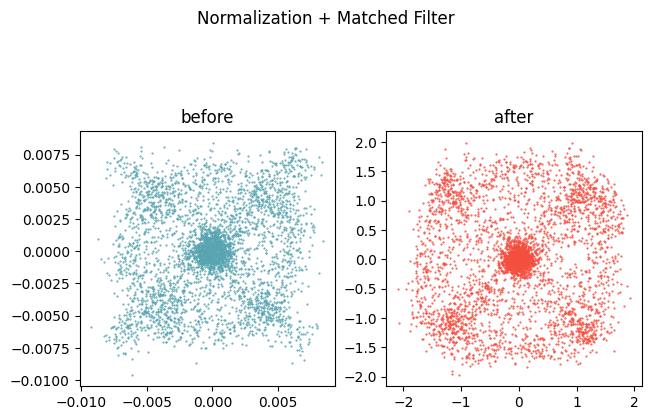

Coarsely estimated frequency offset: 26781.66


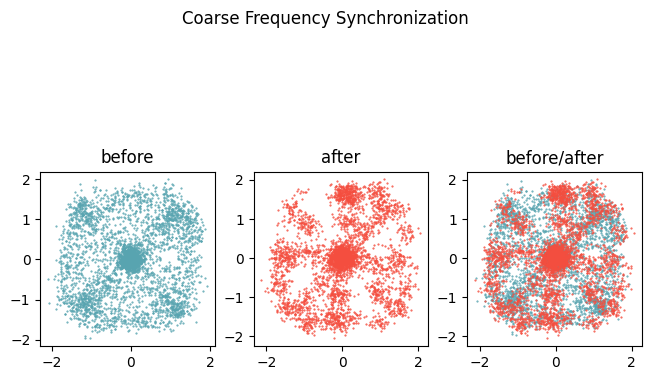

Estimated phase shift: 50.62499999999999°


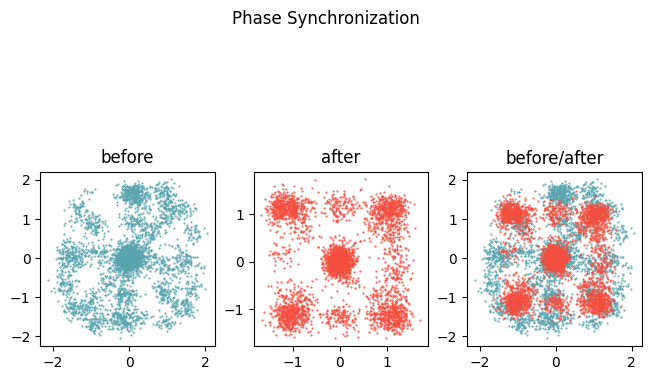

Phase ambiguity: 0.0°, Time offset: -16


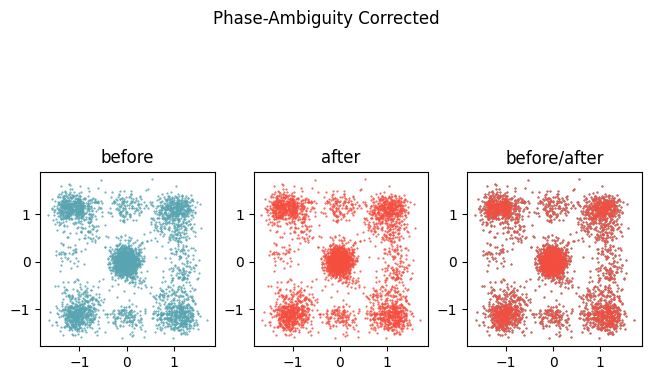

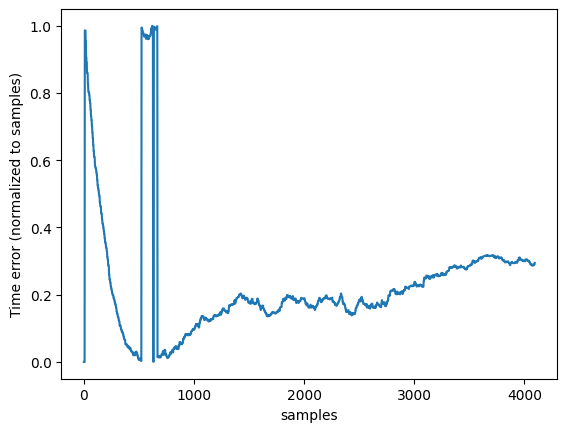

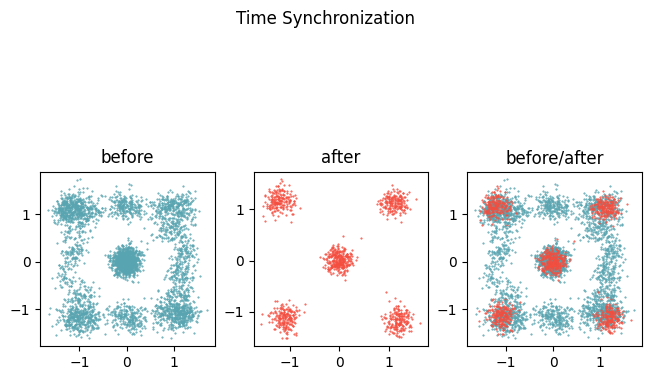

array([ 0.        +0.j        ,  0.8851331 +0.91156805j,
       -1.0052108 +1.1917667j , ...,  0.25942817+0.21040411j,
        0.23127384-0.01148014j, -0.04139458-0.11691807j],
      shape=(1024,), dtype=complex64)

In [152]:
def get_sample_time(plot=False):
    # SETUP
    samples = packet_signal_4096
    samples_size_fft = 4096
    sps = samples_per_symbol
    fs = sampling_freq
    chip_map = ieee802154_chip_map

    payload = payload = [0, 0]

    # PROCESSING
    samples_norm = normalize(samples)
    samples_filt = filter(samples_norm, sps)
    samples_freq, cfo = sync_freq(samples_filt, fs, samples_size_fft, sps)
    # samples_phase_old,phase_error = sync_phase(samples_freq, sps)
    samples_phase, phase_shift = sync_phase2(samples_freq, sps)

    samples_phase2, samples_expected, time_offset, phase_ambiguity = sync_phase_time(samples=samples_phase,
                                                                                     payload=payload, chip_map=chip_map)
    samples_time, time_error = sync_time(samples_phase2, sps)
    if plot:
        def plot_error(error, ylabel):
            plt.plot(error)
            plt.xlabel('samples')
            plt.ylabel(ylabel)
            plt.show()

        plot_eye_cmp(samples, samples_filt, fs, sps, 'before', 'after', 'Normalization + Matched Filter', True,
                     disable_combo=True)
        print("Coarsely estimated frequency offset:", cfo)
        plot_eye_cmp(samples_filt[0:], samples_freq[0:], fs, sps, 'before', 'after', 'Coarse Frequency Synchronization',
                     True)
        print(f"Estimated phase shift: {phase_shift * 180 / np.pi}°")
        # plot_eye_cmp(samples_freq, samples_phase_old, fs, sps, 'before', 'after', 'Phase Synchronization', True)
        # plot_error(phase_error*180/np.pi, "Phase error [°]")
        plot_eye_cmp(samples_freq, samples_phase, fs, sps, 'before', 'after', 'Phase Synchronization', True)
        print(f"Phase ambiguity: {phase_ambiguity * 180 / np.pi}°, Time offset: {time_offset}")
        plot_eye_cmp(samples_phase, samples_phase2, fs, sps, 'before', 'after', 'Phase-Ambiguity Corrected', True)
        plot_error(time_error, "Time error (normalized to samples)")
        plot_eye_cmp(samples_phase2, samples_time, fs, sps, 'before', 'after', 'Time Synchronization', False)

    return samples_time


get_sample_time(True)

In [167]:
from typing import List, Any, Tuple

chip_seqs: List[Tuple[
    int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int, int]] = [
    (1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0),
    (1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0),
    (0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0),
    (0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1),
    (0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1),
    (0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0),
    (1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1),
    (1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1),
    (1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1),
    (1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1),
    (0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1),
    (0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0),
    (0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1),
    (1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0),
    (1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0)
]
# chip_seqs_combined = np.array([list(zip(seq[::2], seq[1::2])) for seq in chip_seqs])

In [206]:
# test_packet_bytes = [0x00, 0x00, 0x00, 0x00, 0xa7, 0x11, 0x01, 0x98, 0x01, 0x22, 0x22, 0x34, 0x12, 0x44, 0x44, 0xcd,
#                      0xab, 0x00, 0x01, 0x02, 0x03, 0x77, 0x27, ]
test_packet = [0x0, 0x0, 0x0, 0x0, 0x0, 0x0, 0x0, 0x0, 0xa, 0x7, 0x1, 0x1, 0x0, 0x1, 0x9, 0x8, 0x0, 0x1, 0x2, 0x2, 0x2,
               0x2, 0x3, 0x4, 0x1, 0x2, 0x4, 0x4, 0x4, 0x4, 0xc, 0xd, 0xa, 0xb, 0x0, 0x0, 0x0, 0x1, 0x0, 0x2, 0x0, 0x3,
               0x7, 0x7, 0x2, 0x7, ]
# reverse endianness b/c networking is weird
test_packet: List[int] = [v for sublist in [*zip(test_packet[1::2], test_packet[::2])] for v in sublist]

In [208]:
from typing import List, Any, Tuple
from scipy.spatial.distance import cosine

preamble = test_packet[:8]
print("len(test_packet)", len(test_packet))


# 1 is same, 0 is least
def similar(input_seq, chip_seq) -> float:
    # get the similarness of each chip sequence, 1 is same ... -1 is inverse
    c = cosine(input_seq, chip_seq)
    return 1 - abs(c)


def get_most_similar_chip_seq(flattened_input_seq) -> (int, float):
    best = 0.0
    best_index = 0xee
    for (index, chip_seq) in enumerate(chip_seqs):
        current = similar(flattened_input_seq, chip_seq)
        if current > best:
            best = current
            best_index = index

    return best_index, best


def point_to_chip(i: int, q: int) -> (int, int):
    if i < 0:
        i = 0
    if q < 0:
        q = 0
    return int(i), int(q)


check_icon = "✅"
x_icon = "❌"


def test():
    samples_time = get_sample_time()
    print("len(samples_time)", len(samples_time))
    I = np.round(np.real(samples_time))
    Q = np.round(np.imag(samples_time))
    together = np.column_stack((I, Q))
    together = np.array([[i, q] for [i, q] in together if i != 0.0 and q != 0.0])  # remove 0s
    together = np.array([point_to_chip(i, q) for [i, q] in together])
    possible_chip_seq = np.array_split(together, np.ceil(len(together) / 16))

    for (i, chip_seq) in enumerate(possible_chip_seq):
        flat = chip_seq.flatten()
        (byte, diff) = get_most_similar_chip_seq(flattened_input_seq=flat)
        correct = byte == test_packet[i]
        if correct:
            print(f"{check_icon}{i}: {hex(byte)} ")
        else:
            print(f"{x_icon}{i}: {hex(byte)} != {hex(test_packet[i])}")
            print(f"\tin  -> {flat}")
            print(f"\texp -> {chip_seqs[test_packet[i]]}")
        # if diff != 1:
        #     print(f"similarity: {diff}")
        #     print(f"\tin  -> {flat}")
        #     print(f"\tsim -> {chip_seqs[byte]}")

    # return together


test()

len(test_packet) 46
len(samples_time) 1024
✅0: 0x0 
✅1: 0x0 
✅2: 0x0 
✅3: 0x0 
✅4: 0x0 
✅5: 0x0 
✅6: 0x0 
✅7: 0x0 
✅8: 0x7 
✅9: 0xa 
✅10: 0x1 
✅11: 0x1 
✅12: 0x1 
✅13: 0x0 
✅14: 0x8 
✅15: 0x9 
✅16: 0x1 
✅17: 0x0 
✅18: 0x2 
✅19: 0x2 
✅20: 0x2 
✅21: 0x2 
✅22: 0x4 
✅23: 0x3 
✅24: 0x2 
✅25: 0x1 
✅26: 0x4 
✅27: 0x4 
✅28: 0x4 
✅29: 0x4 
✅30: 0xd 
✅31: 0xc 
✅32: 0xb 
✅33: 0xa 
✅34: 0x0 
✅35: 0x0 
✅36: 0x1 
✅37: 0x0 
✅38: 0x2 
✅39: 0x0 
✅40: 0x3 
✅41: 0x0 
✅42: 0x7 
✅43: 0x7 
✅44: 0x7 
✅45: 0x2 
